In [1]:
from ground_data import GroundObservations
from LOCSS_data_structure import GaugeCollection
import importlib
import pandas as pd
import os
import datetime as dt
%load_ext autoreload
%autoreload 2

In [28]:
#Generate each lake in a folder
go=GroundObservations()
df_locss_podaac=go.get_locss('LOCSS', all_fds=True)

g_path='../data/locss_2_podaac/by_st'
f_exist=os.path.exists(g_path)
stations=df_locss_podaac['gauge_id'].unique()
df_locss_podaac.rename(columns={'name_x':'name_at_measurement', 'notes_x':'reading_notes', 'name_y':'lake_name',
                                       'notes_y':'installation_notes'}, inplace=True)
st_fields=['gauge_id','lake_name','date','height','is_bubble_level_okay','installation_notes', 'city','latitude','longitude','timezone',
           'unit','min_height','max_height','installation_date','initial_reading','reading_notes', 'updated_at']
df_locss_podaac=df_locss_podaac[st_fields].copy()
if not f_exist:
    os.makedirs(g_path)
for st in stations:
    st_path=g_path+'/'+st
    f_st_exist=os.path.exists(st_path)
    if not f_st_exist:
        os.makedirs(st_path)
    df=df_locss_podaac.loc[df_locss_podaac['gauge_id']==st]
    df.to_csv(st_path+'/LOCSS_'+st+'.csv')

In [25]:
df_locss_podaac.columns


Index(['gauge_id', 'lake_name', 'date', 'height', 'is_bubble_level_okay',
       'installation_notes', 'city', 'latitude', 'longitude', 'timezone',
       'unit', 'min_height', 'max_height', 'installation_date',
       'initial_reading', 'reading_notes', 'updated_at'],
      dtype='object')

In [33]:
#read with no merge for po.daac
dt_fields=['gauge_id','name_x','date','height','is_bubble_level_okay','notes_x']
st_fields=['gauge_id','name','city','latitude','longitude','timezone','unit','min_height','max_height','installation_date','initial_reading','notes', 'updated_at']

dir_ts='../data/readings_up_to_20220404.csv'
dir_loc='../data/gauges_up_to_20220404.csv'
id_fd='gauge_id'
date_fd='date'
time_fd='time'
height_fd='height'
df_locss=pd.read_csv(dir_ts)
df_coord_locss=pd.read_csv(dir_loc, sep=",")
gc=GaugeCollection()

df_locss_filtered=gc.filter_test_gages(df_locss,id_fd).copy()
df_locss_filtered=pd.merge(df_locss_filtered, df_coord_locss, on=id_fd)
df_locss_filtered=df_locss_filtered.loc[(df_locss_filtered[height_fd]>=df_locss_filtered['min_height'])&
                                        (df_locss_filtered[height_fd]<=df_locss_filtered['max_height'])].copy()
df_locss_filtered[date_fd]=pd.to_datetime((df_locss_filtered[date_fd].astype(str)+' '+df_locss_filtered[time_fd].astype(str)), 
                                                  format='%Y-%m-%d %H:%M:%S')


In [34]:
df_locss_filtered=df_locss_filtered[dt_fields]
df_locss_filtered.rename(columns={'name_x':'name', 'notes_x':'notes'}, inplace=True)
df_coord_locss=df_coord_locss[st_fields]
out_path='../data/locss_2_podaac/st_rd/'
f_exist=os.path.exists(out_path)
if not f_exist:
    os.makedirs(out_path)
df_locss_filtered.to_csv(out_path+'locss_readings_up_to_20220404.csv', index=False)
df_coord_locss.to_csv(out_path+'locss_gauges_up_to_20220404.csv', index=False)

In [67]:
#Test getting brasilian ts
import pandas as pd
import os


def _get_all_lakes(file_list, by=None):
    df=pd.DataFrame(file_list, columns=['file_name'])
    df_ex=df['file_name'].str.split('_', expand=True)
    
    df_ex=df_ex.rename(columns={0:'location',1:'lake_id',2:'name'})
    df_ex['name']=df_ex['name'].apply(lambda x:x[:-4])
    df_all=pd.concat((df,df_ex), axis=1)
    if by=='lake_id':
        return df_all['lake_id']
    elif by=='name':
        return df_all['name']
    else:
        return df_all
postfix='.xlsx'
path='../data/brasil/'
files = [f for f in os.listdir(path) if (os.path.isfile(os.path.join(path, f))&
                                                  (f.endswith(postfix)))]
files
start_st=3
end_st=8
st=[f[start_st:end_st] for f in files]
for s in st:
    print(files[st.index(s)])
    
# type(get_all_lakes(data, by='lake_id'))
# type(get_all_lakes(data, by=None))
# type(get_all_lakes(data, by='name'))
# _get_all_lakes(files, by='lake_id')
# df=_get_all_lakes(files, by=None)

# for index, row in df.iterrows():
#     print(row['file_name'])
#     df=pd.read_excel(path+row['file_name'])
#     break
# # [f[] for f in files] 
# df
# f[:-len(postfix)][-length_id:]
# _get_all_lakes(files, by='name')
# df_coord['lon_tx'].astype(float)/100

br_19069_MACHADINHO.xlsx
br_19126_XINGO.xlsx
br_19060_SEGREDO.xlsx


In [ ]:
#To test what is faster 

import xlrd
import timeit

path='/home/angelica/Documents/py_linux/pylocss/data/brasil/br_19126_XINGO.ods'
# xlrd.open_workbook(filename=path)
%timeit pd.read_excel(path, engine='odf')

In [ ]:
path='/home/angelica/Documents/py_linux/pylocss/data/brasil/br_19126_XINGO.xlsx'
# xlrd.open_workbook(filename=path)
%timeit pd.read_excel(path)

In [71]:
from ts_preprocesing import *
%load_ext autoreload
%autoreload 2


In [89]:
#test new function load altis with changes 
g_path='/home/angelica/Dropbox/apps/python_pychm/locss/data/alti_timeseries/'
altis_name='AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017'
altis_name='AlTiS_TimeSeries_Sentinel-3A_0749_S4016'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
wse_ref='g'
(altiyear, altimonth, altiday, altihour, altiminute, altiwelev)=load_altis(g_path+altis_name+'.csv', 
                                                                               altis_date_fd, altis_height_fd, nodataalti=-9999, wse_ref=wse_ref)

altiwelev

array([639.41776294, 638.79814716, 639.03307506, 639.08598951,
       638.9512785 , 639.22153111, 639.86431209, 639.76201283,
       639.94931077, 639.9821185 , 639.57211619, 639.297528  ,
       639.25073062, 639.17055127, 639.08187817, 639.40142945,
       639.39348567, 639.89583095, 639.7917532 , 640.25812196,
       640.10360696, 640.42202405, 640.42524257, 640.13159718,
       639.72194669, 639.1764573 , 639.00231116, 639.25268834,
       639.51002587, 639.60377963, 639.87170993, 640.49675565,
       640.03452703, 639.76819589, 640.20760798, 640.47443189,
       640.08513394, 639.50381148, 639.14197758, 638.95128786,
       639.06035578, 639.00788169, 639.46582925, 639.97037448,
       639.85536325, 640.67367134, 640.45245077, 640.07032121,
       640.21899268, 640.52368635, 639.96197048, 640.11167615,
       639.65527678, 639.47112128, 639.53081034, 639.4678867 ,
       640.09827893, 640.31512617, 640.54360892, 640.50777014,
       640.37066558, 640.49162851, 640.7388485 , 640.60

In [92]:
#test new function load altis with changes 
g_path='/home/angelica/Dropbox/apps/python_pychm/locss/data/alti_timeseries/'
altis_name='AlTiS_TimeSeries_Sentinel-3A_0749_S4016'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
wse_ref='e'
ncolgeoid='geoid_01_median'
(altiyear1, altimonth, altiday, altihour, altiminute, altiwelev1)=load_altis(g_path+altis_name+'.csv', 
                                                                            altis_date_fd, altis_height_fd, ncolgeoid=ncolgeoid,
                                                                            nodataalti=-9999, wse_ref=wse_ref)

altiwelev1

array([663.07981069, 662.47482143, 662.70496378, 662.74140667,
       662.61090978, 662.86109502, 663.50252798, 663.39862791,
       663.5459598 , 663.63459361, 663.22171309, 662.94419173,
       662.90517984, 662.82497422, 662.71601449, 663.08318062,
       663.0269616 , 663.57564589, 663.43465858, 663.93466536,
       663.75011991, 664.06734304, 664.06818937, 663.76005322,
       663.35692908, 662.83904057, 662.65802611, 662.89198135,
       663.16243485, 663.24401847, 663.51795276, 664.16366049,
       663.7086631 , 663.43072491, 663.87263624, 664.13096986,
       663.74833067, 663.14252579, 662.7969605 , 662.60973331,
       662.70915986, 662.64661454, 663.1199493 , 663.60987749,
       663.51366899, 664.33485192, 664.10550297, 663.71663475,
       663.86306733, 664.15908874, 663.61175306, 663.31361751,
       662.86337152, 662.66698005, 662.73149651, 662.6737999 ,
       663.30699027, 663.51799969, 663.74929344, 663.69564737,
       663.58061859, 663.69830568, 663.94073831, 663.81

In [100]:
#Making the correction from whole code

text=['AlTiS_TimeSeries_Sentinel-3A_0562_S4128', 'AlTiS_TimeSeries_Sentinel-3B_0026_N4814', 'AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017']
s=[f.find('Sentinel-3') for f in text]
for v in s:
    if v!=-1:
        print('get ellipsoide')
    else:
        print('get geoide')

get ellipsoide
get ellipsoide
get geoide


In [114]:
def get_common_period(df_ts1, df_ts2, date_ts1_fd, date_ts2_fd, delta_days=False, ndays=0):
    '''Get the common period of time between two time series, df_ts1 and df_ts2
        WARNING: If not timezone information in any of the dataframe, utc is assumed 
        It can return the common period + or - a number of days based on df_ts1
        Assume both dataframe datetime is utc
        If delta_days=False, ndays is assume =0, returns a common dataframe with the interception between the two dataframes
        If delta_days=True, ndays has to be different from 0
            Rules:
                if df_ts1 starts earlier than df_ts2, common period starts at initial time of df_ts2
                if df_ts1 starts later than df_ts2, common period starts ndays earlier than initial time of df_ts1
                if df_ts1 ends earlier than df_ts2, common period ends ndays later than final time of df_ts1
                if df_ts1 ends later than df_ts2, common period end at the final time of df_ts2
    '''
    
    if delta_days==True and ndays<=0:
        #TODO:Convert this to raise exceptions
        print('Error ndays cannot be 0 or lower if delta_days=True')
        return None
    if delta_days==False:
        ndays=0
    
    utc=pytz.utc
    
    #Min and max dates in df_ts1 and df_ts2
    if df_ts1[date_ts1_fd].dt.tz is None:
        df_ts1[date_ts1_fd]=[utc.localize(date) for date in df_ts1[date_ts1_fd]]
        
    if df_ts2[date_ts2_fd].dt.tz is None:
        df_ts2[date_ts2_fd]=[utc.localize(date) for date in df_ts2[date_ts2_fd]]
        
    earlier_date_ts1=min(df_ts1[date_ts1_fd])
    final_date_ts1=max(df_ts1[date_ts1_fd])
        
    earlier_date_ts2=min(df_ts2[date_ts2_fd])
    final_date_ts2=max(df_ts2[date_ts2_fd])

    if earlier_date_ts1 >= earlier_date_ts2:
        initial_date=earlier_date_ts1 - dt.timedelta(days=ndays)
    else:
        initial_date=earlier_date_ts2

    if final_date_ts1 >= final_date_ts2:
        end_date=final_date_ts2
    else:
        end_date=final_date_ts1 + dt.timedelta(days=ndays)
    
    #filter dataframes
    df_ts1=df_ts1.loc[(df_ts1[date_ts1_fd]>=initial_date)&(df_ts1[date_ts1_fd]<=end_date)].copy()
    df_ts2=df_ts2.loc[(df_ts2[date_ts2_fd]>=initial_date)&(df_ts2[date_ts2_fd]<=end_date)].copy()
    
    return (df_ts1, df_ts2)


In [135]:
import pandas as pd
import pytz
from datetime import datetime, timezone
import datetime as dt

s_dict={'date': ['2001-12-20','2002-01-05','2002-01-15','2002-02-04','2002-02-09'], 'val':[1.5,2,2.4,3,2]}
g_dict={'date': ['2002-01-01','2002-01-02','2002-01-03',
                 '2002-01-04','2002-01-05','2002-01-06',
                '2002-01-08','2002-01-10','2002-01-14',
                '2002-01-15','2002-01-18','2002-01-20',
                '2002-01-21','2002-02-07','2002-02-08'], 'val':[1.5,2,1,
                                                                2,2.4,3,
                                                               2,2.1,2.2,
                                                               2,1,1,
                                                               2,2.5,1]}
df_s=pd.DataFrame(s_dict)
df_s['date']=pd.to_datetime(df_s['date'], utc=True)

df_g=pd.DataFrame(g_dict)
df_g['date']=pd.to_datetime(df_g['date'])#, utc=True)
df_g['date'].dt.tz

In [136]:
df_s

,date,val
0,2001-12-20 00:00:00+00:00,1.5
1,2002-01-05 00:00:00+00:00,2.0
2,2002-01-15 00:00:00+00:00,2.4
3,2002-02-04 00:00:00+00:00,3.0
4,2002-02-09 00:00:00+00:00,2.0


In [137]:
df_g

,date,val
0,2002-01-01,1.5
1,2002-01-02,2.0
2,2002-01-03,1.0
3,2002-01-04,2.0
4,2002-01-05,2.4
5,2002-01-06,3.0
6,2002-01-08,2.0
7,2002-01-10,2.1
8,2002-01-14,2.2
9,2002-01-15,2.0


In [138]:
df_sx, df_gx=get_common_period(df_ts1=df_s, df_ts2=df_g, date_ts1_fd='date', date_ts2_fd='date', delta_days=True, ndays=2)

In [139]:
df_sx

,date,val
1,2002-01-05 00:00:00+00:00,2.0
2,2002-01-15 00:00:00+00:00,2.4
3,2002-02-04 00:00:00+00:00,3.0


In [140]:
df_gx

,date,val
0,2002-01-01 00:00:00+00:00,1.5
1,2002-01-02 00:00:00+00:00,2.0
2,2002-01-03 00:00:00+00:00,1.0
3,2002-01-04 00:00:00+00:00,2.0
4,2002-01-05 00:00:00+00:00,2.4
5,2002-01-06 00:00:00+00:00,3.0
6,2002-01-08 00:00:00+00:00,2.0
7,2002-01-10 00:00:00+00:00,2.1
8,2002-01-14 00:00:00+00:00,2.2
9,2002-01-15 00:00:00+00:00,2.0


In [141]:


def filter_date(df, date, delta, v_fd, d_fd):
    df_t=df.loc[(df[d_fd]>=(date-dt.timedelta(days=delta)))&(df[d_fd]<=(date+dt.timedelta(days=delta)))]
    return df_t[v_fd].median(skipna=True),df_t[v_fd].mean(skipna=True), df_t[v_fd].count()

# df_s[['mv','md']]=
# print(
delta=2
median_fd='median_d_'+str(delta)
mean_fd='mean_d_'+str(delta)
count_fd='count_d_'+str(delta)

df_s[[median_fd,mean_fd, count_fd]]=df_sx.apply(lambda x: filter_date(df_gx,x['date'],delta,'val','date'), axis=1).apply(pd.Series)

# for index, row in df_s.iterrows():
#     print(row['date']-dt.timedelta(days=2))
#     print(row['date']+dt.timedelta(days=2))
#     df_t=df_g.loc[(df_g['date']>=(row['date']-dt.timedelta(days=2)))&(df_g['date']<=(row['date']+dt.timedelta(days=2)))]
#     print(df_t, '\n')
#     mean_x=df_t['val'].median()
#     print(mean_x, df_t)
df_s

,date,val,median_d_2,mean_d_2,count_d_2
0,2001-12-20 00:00:00+00:00,1.5,NaN,NaN,NaN
1,2002-01-05 00:00:00+00:00,2.0,2.2,2.1,4.0
2,2002-01-15 00:00:00+00:00,2.4,2.1,2.1,2.0
3,2002-02-04 00:00:00+00:00,3.0,NaN,NaN,0.0
4,2002-02-09 00:00:00+00:00,2.0,NaN,NaN,NaN


In [88]:
#Read all the data from Bangladehs original data files
import pandas as pd
import numpy as np

#Read locss gauges for codes 
#Read Excel file 
path_to_read='C:/Users/amgomez/Dropbox/Research/LOCSS/Docs/Bangladesh_Data September_December.xlsx'
xl=pd.ExcelFile(path_to_read)

list_names=xl.sheet_names
print(len(list_names))
lk_name_fd='lake_name'
df_final=pd.DataFrame() #final dataframe with all data include duplicates
df_final_ndp=pd.DataFrame() #final dataframe removing duplicates. Leaving the last value 
df_duplicates=pd.DataFrame()#final dataframe with all the dates that repeat
for lk_name in list_names:
    
    df=pd.read_excel(path_to_read, sheet_name=lk_name)
    #print (df.shape)
    date_fd=df.columns[0] #Assuming date is always in the first column
    height_fd=df.columns[1]
    df['source']='LOCSS'
    df[lk_name_fd]=lk_name
    #df[id_fd]=station_id #Pending to get the station
    df=df.rename(columns={height_fd:'height',date_fd:'Date'}) #Unify the name of the stations
    date_fd='Date'
    height_fd='height'
    try: 
        df[date_fd]=pd.to_datetime(df[date_fd])
    except Exception as e:
        print ('Error in '+lk_name,e)
    else:
        df=df.sort_values(by=date_fd)
        df['diff_val']=df[height_fd].diff()
        df['diff_date']=df[date_fd].diff().apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
        date_duplicate_mask=df[date_fd].duplicated(keep=False)
        #print('Duplicated\n',date_duplicate_mask)
        df_dp=df[date_duplicate_mask].copy()
        df_ndp=df.drop_duplicates(subset=[date_fd, lk_name_fd], keep='last').copy()
        #concat to final dataframes
        df_final=pd.concat((df_final, df), axis=0)
        df_duplicates=pd.concat((df_duplicates, df_dp), axis=0)
        df_final_ndp=pd.concat((df_final_ndp, df_ndp), axis=0)
    # break
print('\n All data with duplicates', '\n'+str(df_final.shape))
print('\n Only Duplicates\n',str(df_duplicates.shape))
print('\nAll data NO Duplicates\n',str(df_final_ndp.shape))

len(df_final[lk_name_fd].unique())
 

50
Error in Talar Haor Sunamganj Unknown string format: no data 

 All data with duplicates 
(10584, 7)

 Only Duplicates
 (704, 7)

All data NO Duplicates
 (10215, 7)


49

In [89]:
#Identify if the duplicates are the same or not
df_dp=df_duplicates.copy()
df_dp['is_0']=['Yes' if x==0 else 'No' for x in df_dp['diff_val']]
df_dp

,Date,height,source,lake_name,diff_val,diff_date,Unnamed: 2,is_0
0,2021-09-01 09:00:00,7.25,LOCSS,Medol Haor Sylhet,NaN,0,NaN,No
1,2021-09-01 09:00:00,7.25,LOCSS,Medol Haor Sylhet,0.00,0,NaN,Yes
2,2021-09-01 15:00:00,7.26,LOCSS,Medol Haor Sylhet,0.01,360,NaN,No
3,2021-09-01 15:00:00,7.21,LOCSS,Medol Haor Sylhet,-0.05,0,NaN,No
10,2021-09-04 09:00:00,10.77,LOCSS,Medol Haor Sylhet,-0.23,1080,NaN,No
...,...,...,...,...,...,...,...,...
73,2021-10-06 15:00:00,6.47,LOCSS,Putiyar Haor Netrokona,-0.01,0,NaN,No
68,2021-10-06 09:00:00,6.79,LOCSS,Buai Haor Netrokona,-0.01,1080,NaN,No
69,2021-10-06 09:00:00,6.79,LOCSS,Buai Haor Netrokona,0.00,0,NaN,Yes
70,2021-10-06 15:00:00,6.79,LOCSS,Buai Haor Netrokona,0.00,360,NaN,Yes


In [95]:
#Get amount of non-equal duplicates per date 
df_count_dp=df_duplicates.loc[df_duplicates['diff_val']!=0].groupby([date_fd, lk_name_fd],as_index=False).size()
df_count_dp
#Get amount of non-equal duplicates by lake and size
df_count_dp_by_lake=df_count_dp.rename(columns={'size':'class'}).groupby([lk_name_fd, 'class'], as_index=False).size()
df_count_dp_by_lake=df_count_dp_by_lake.sort_values(by=lk_name_fd)

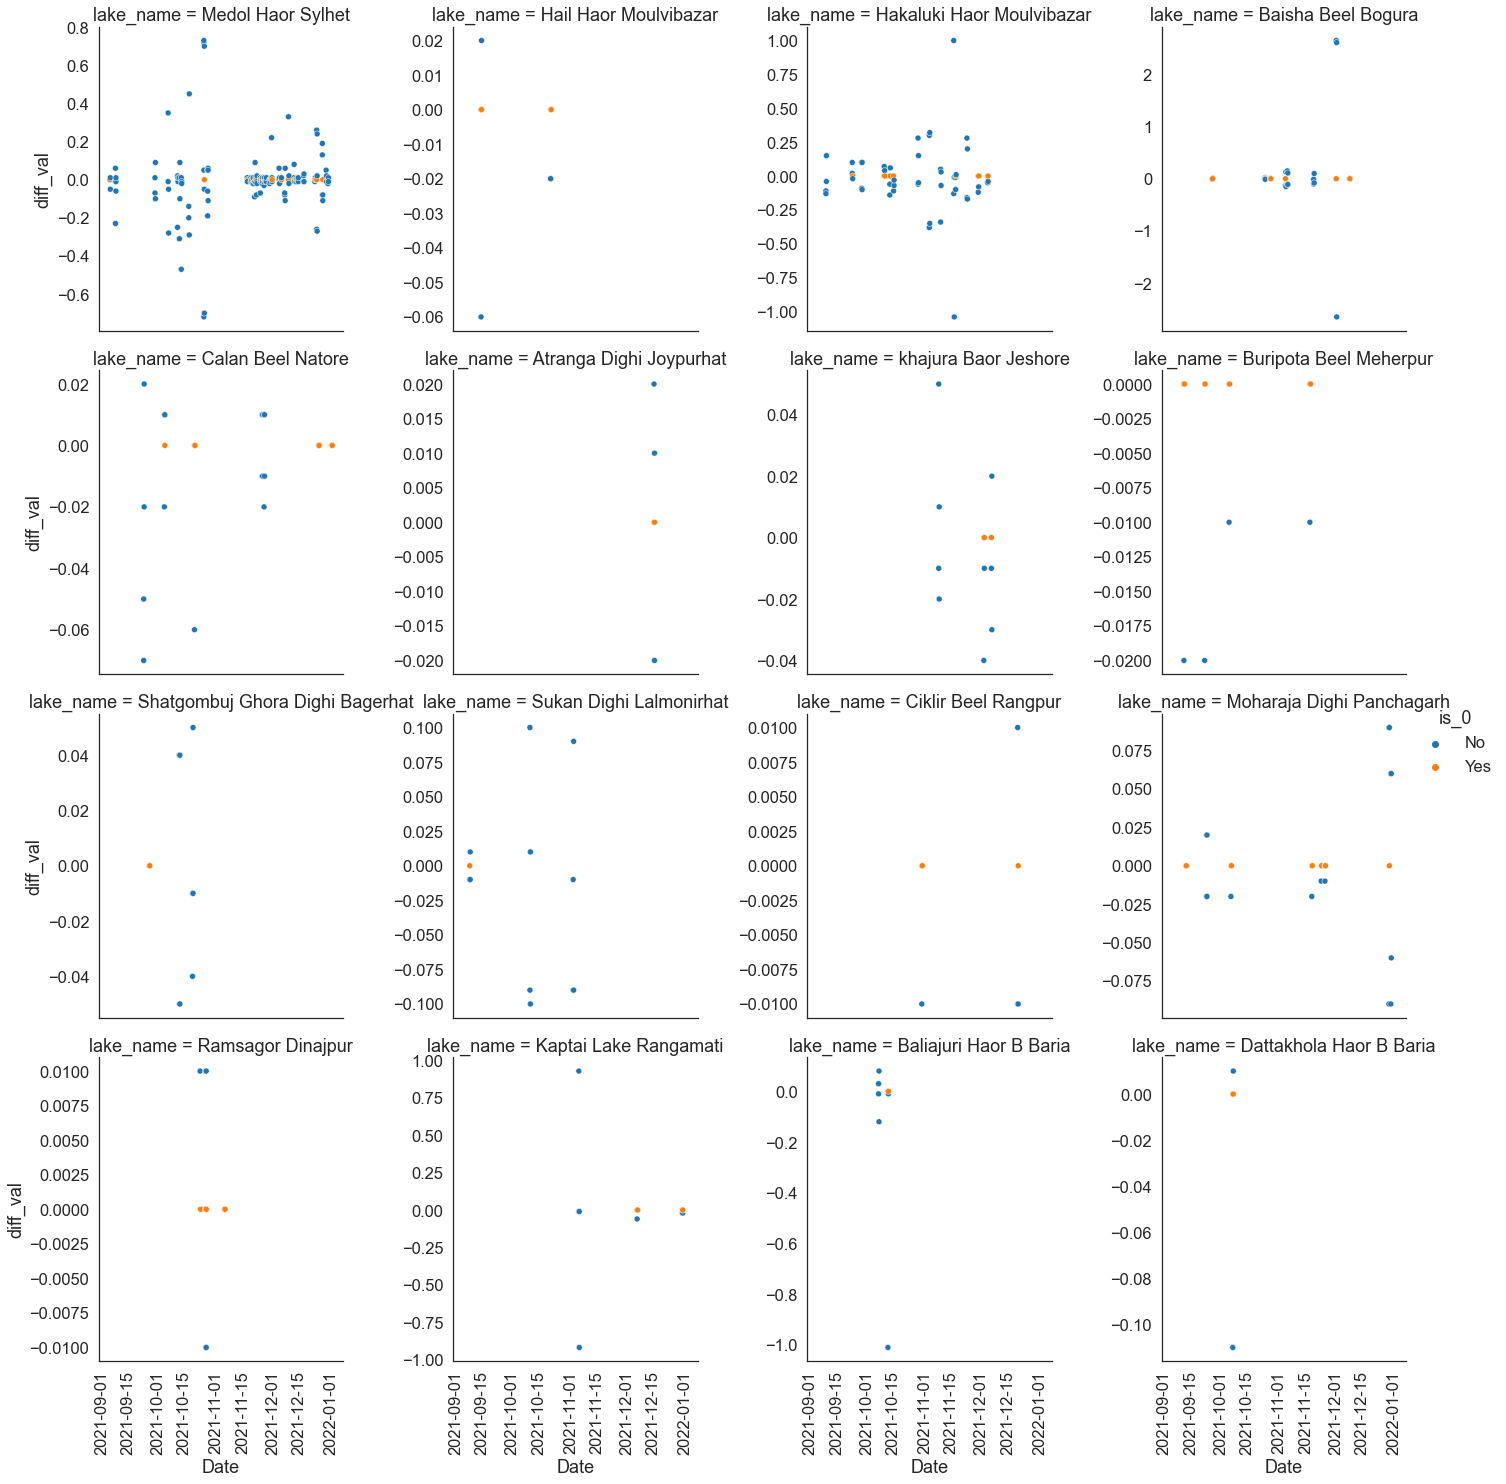

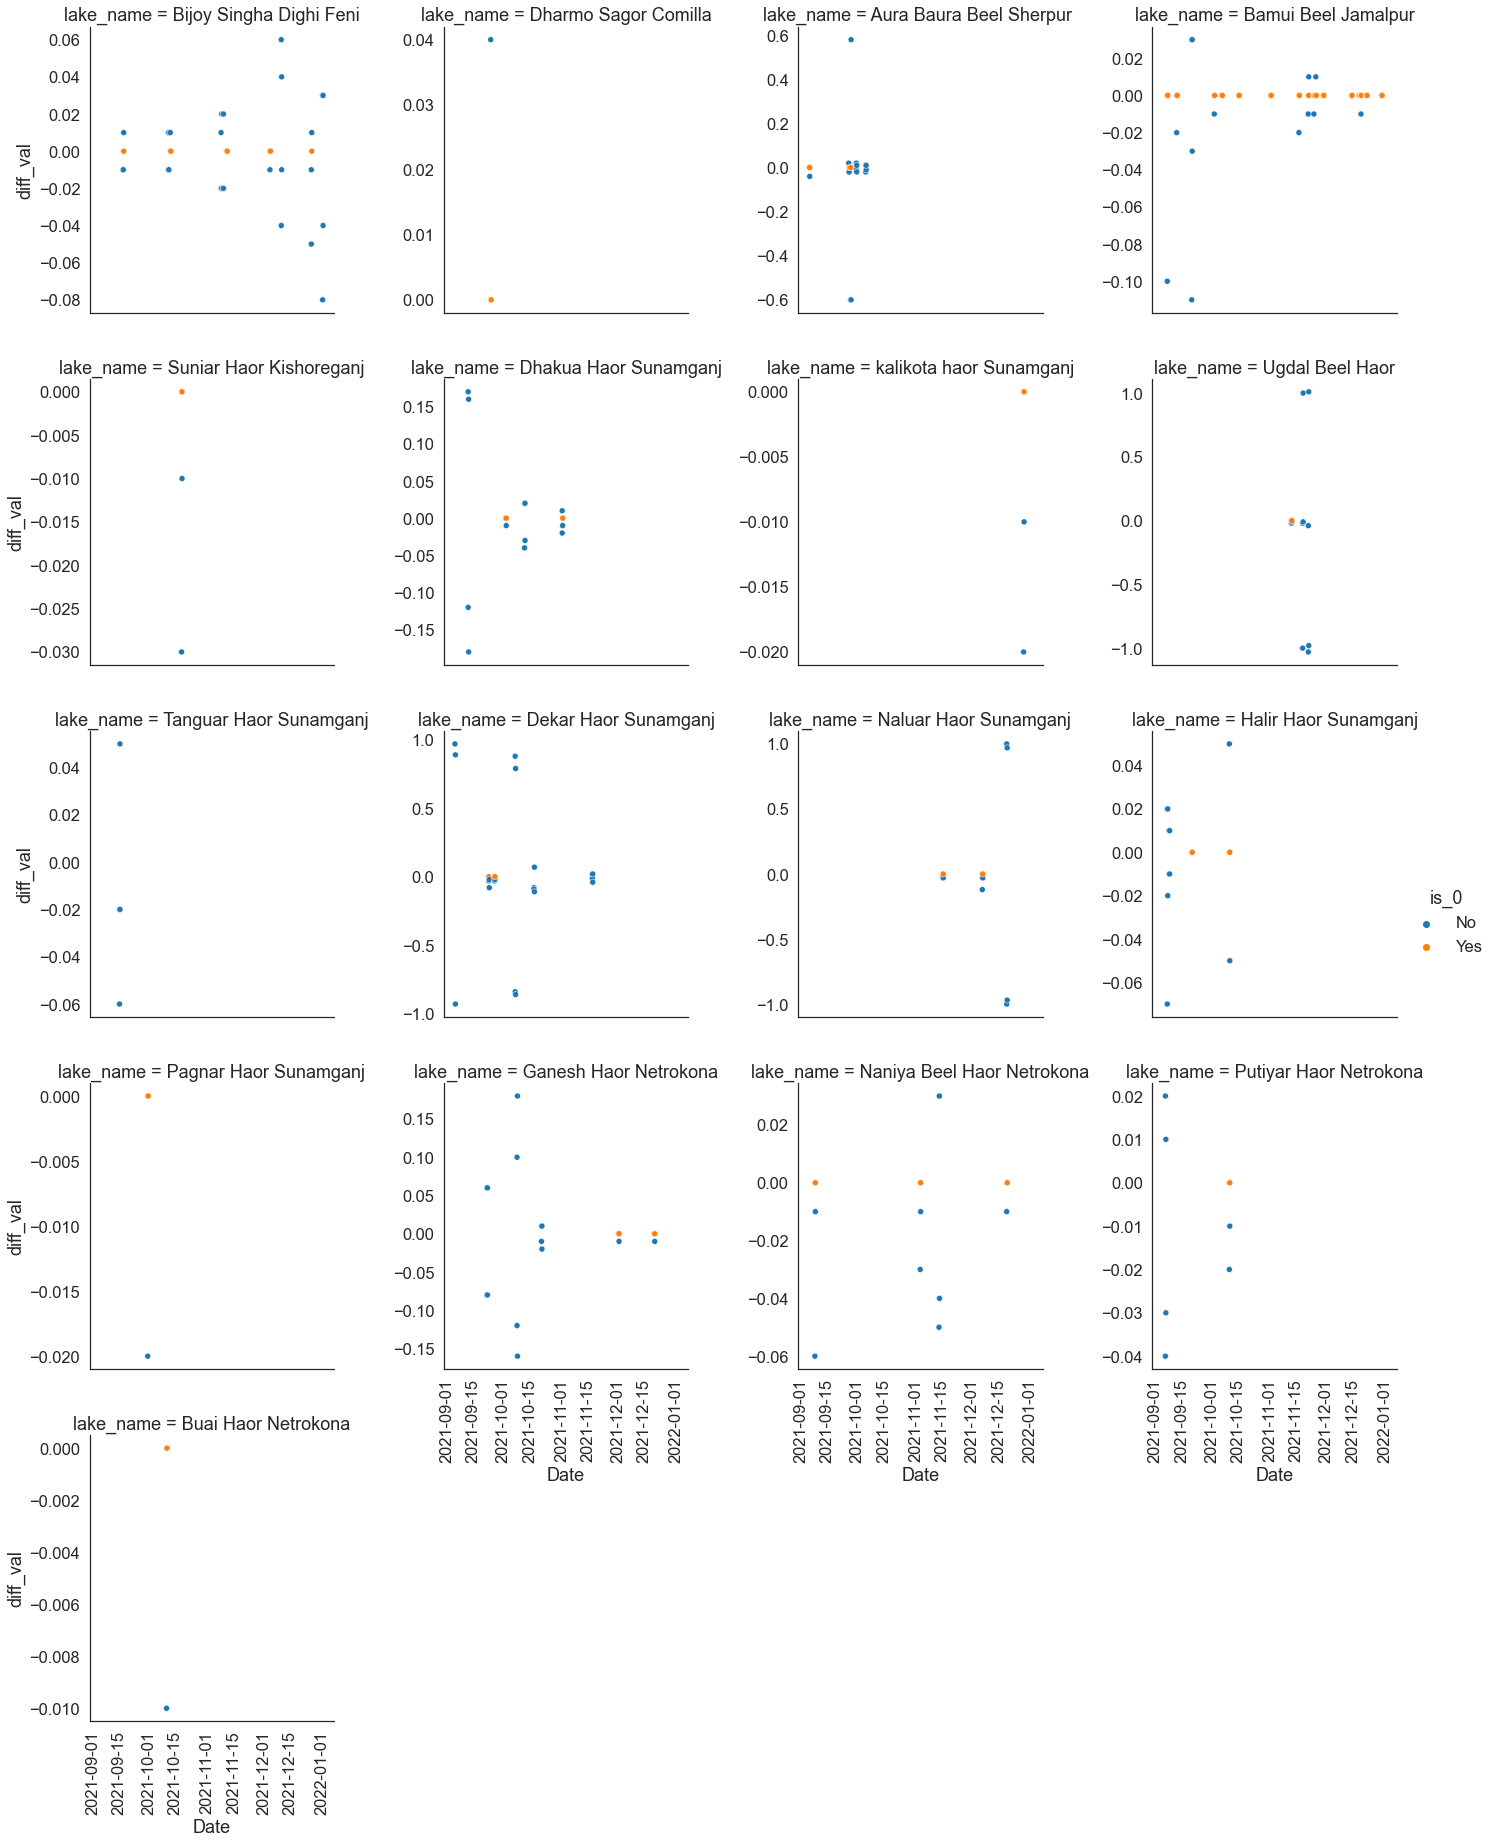

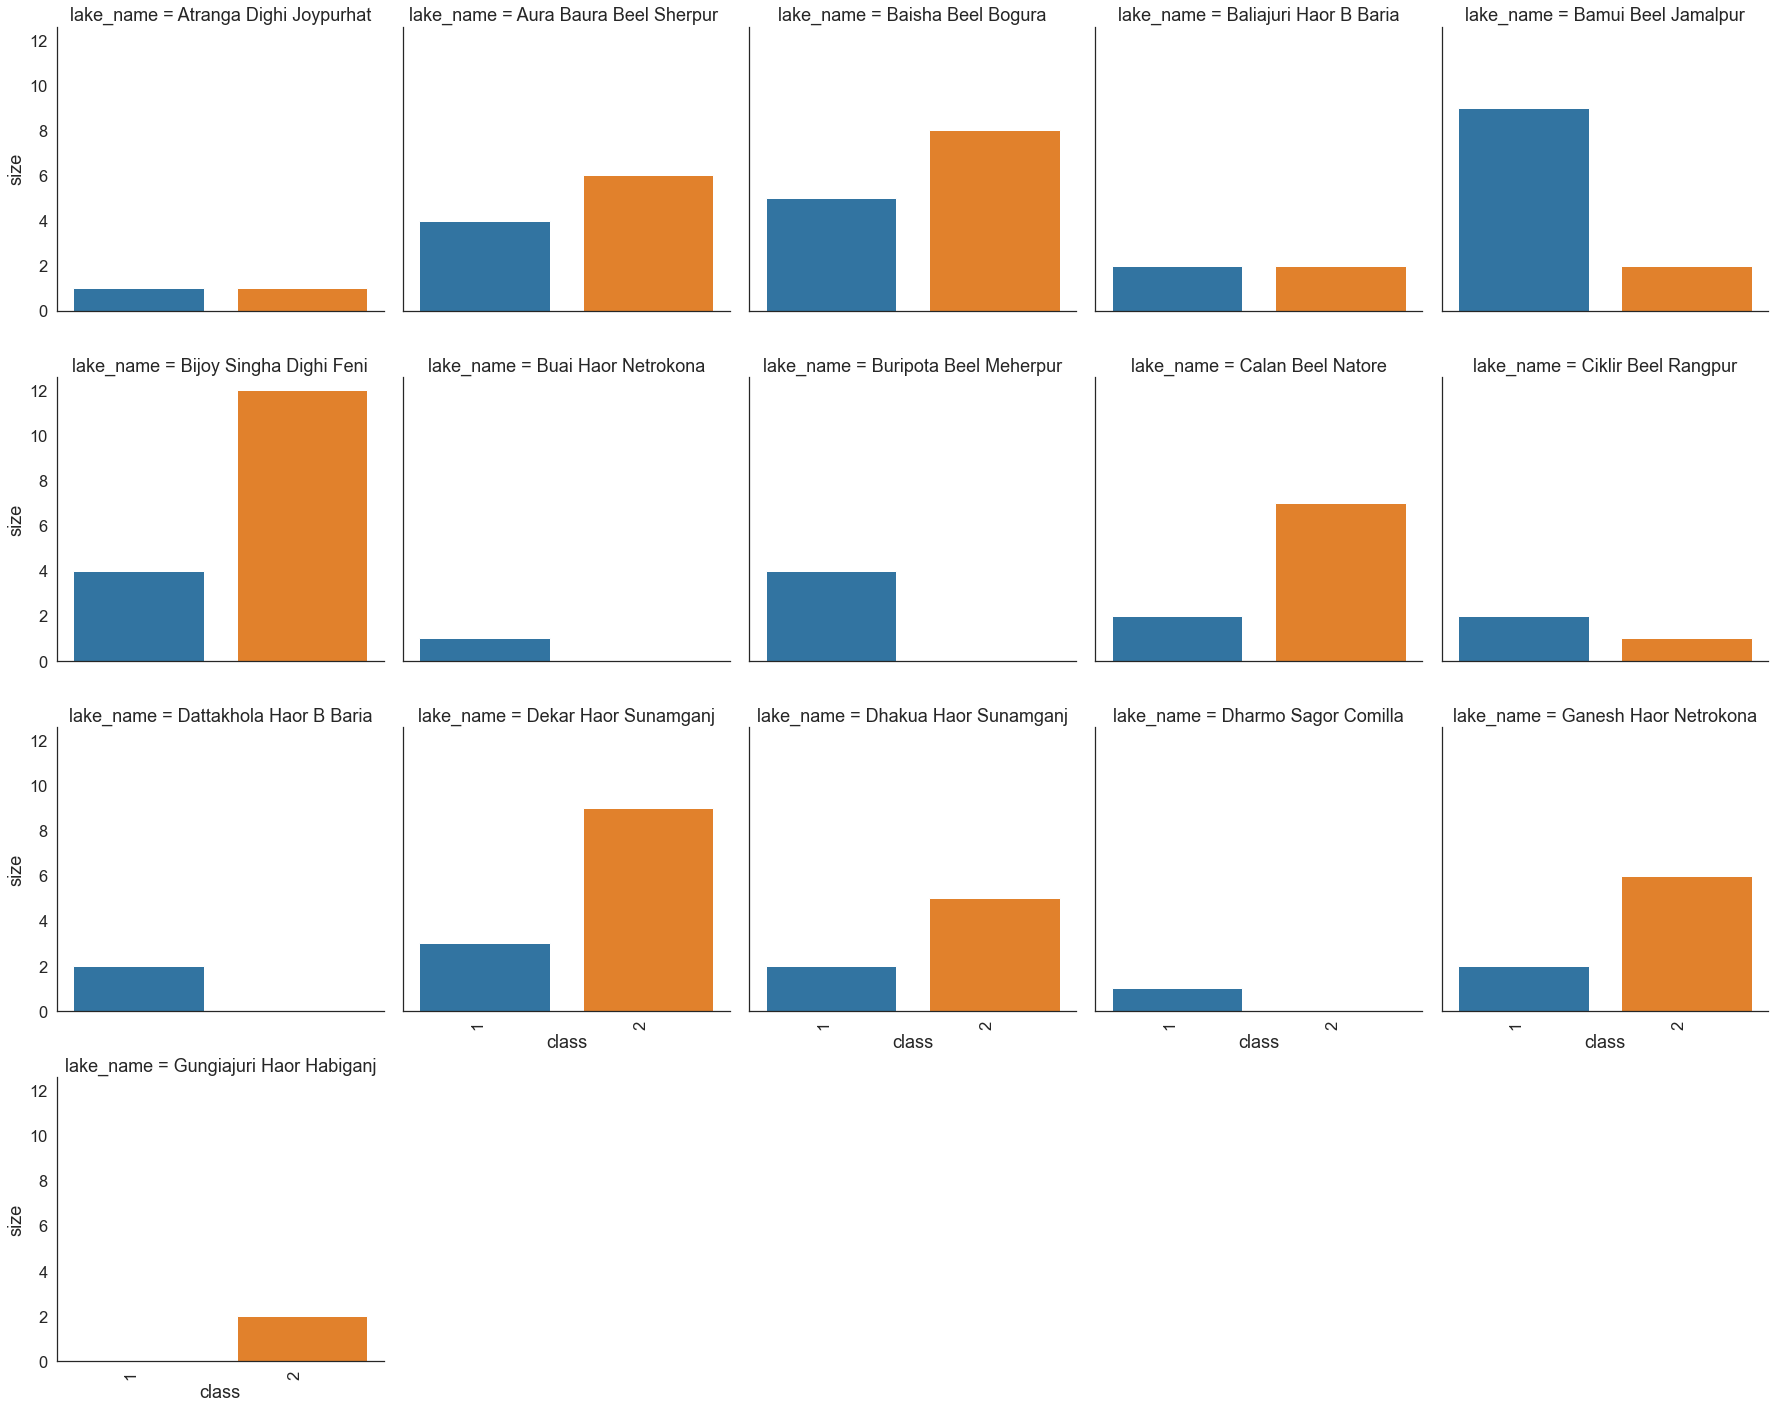

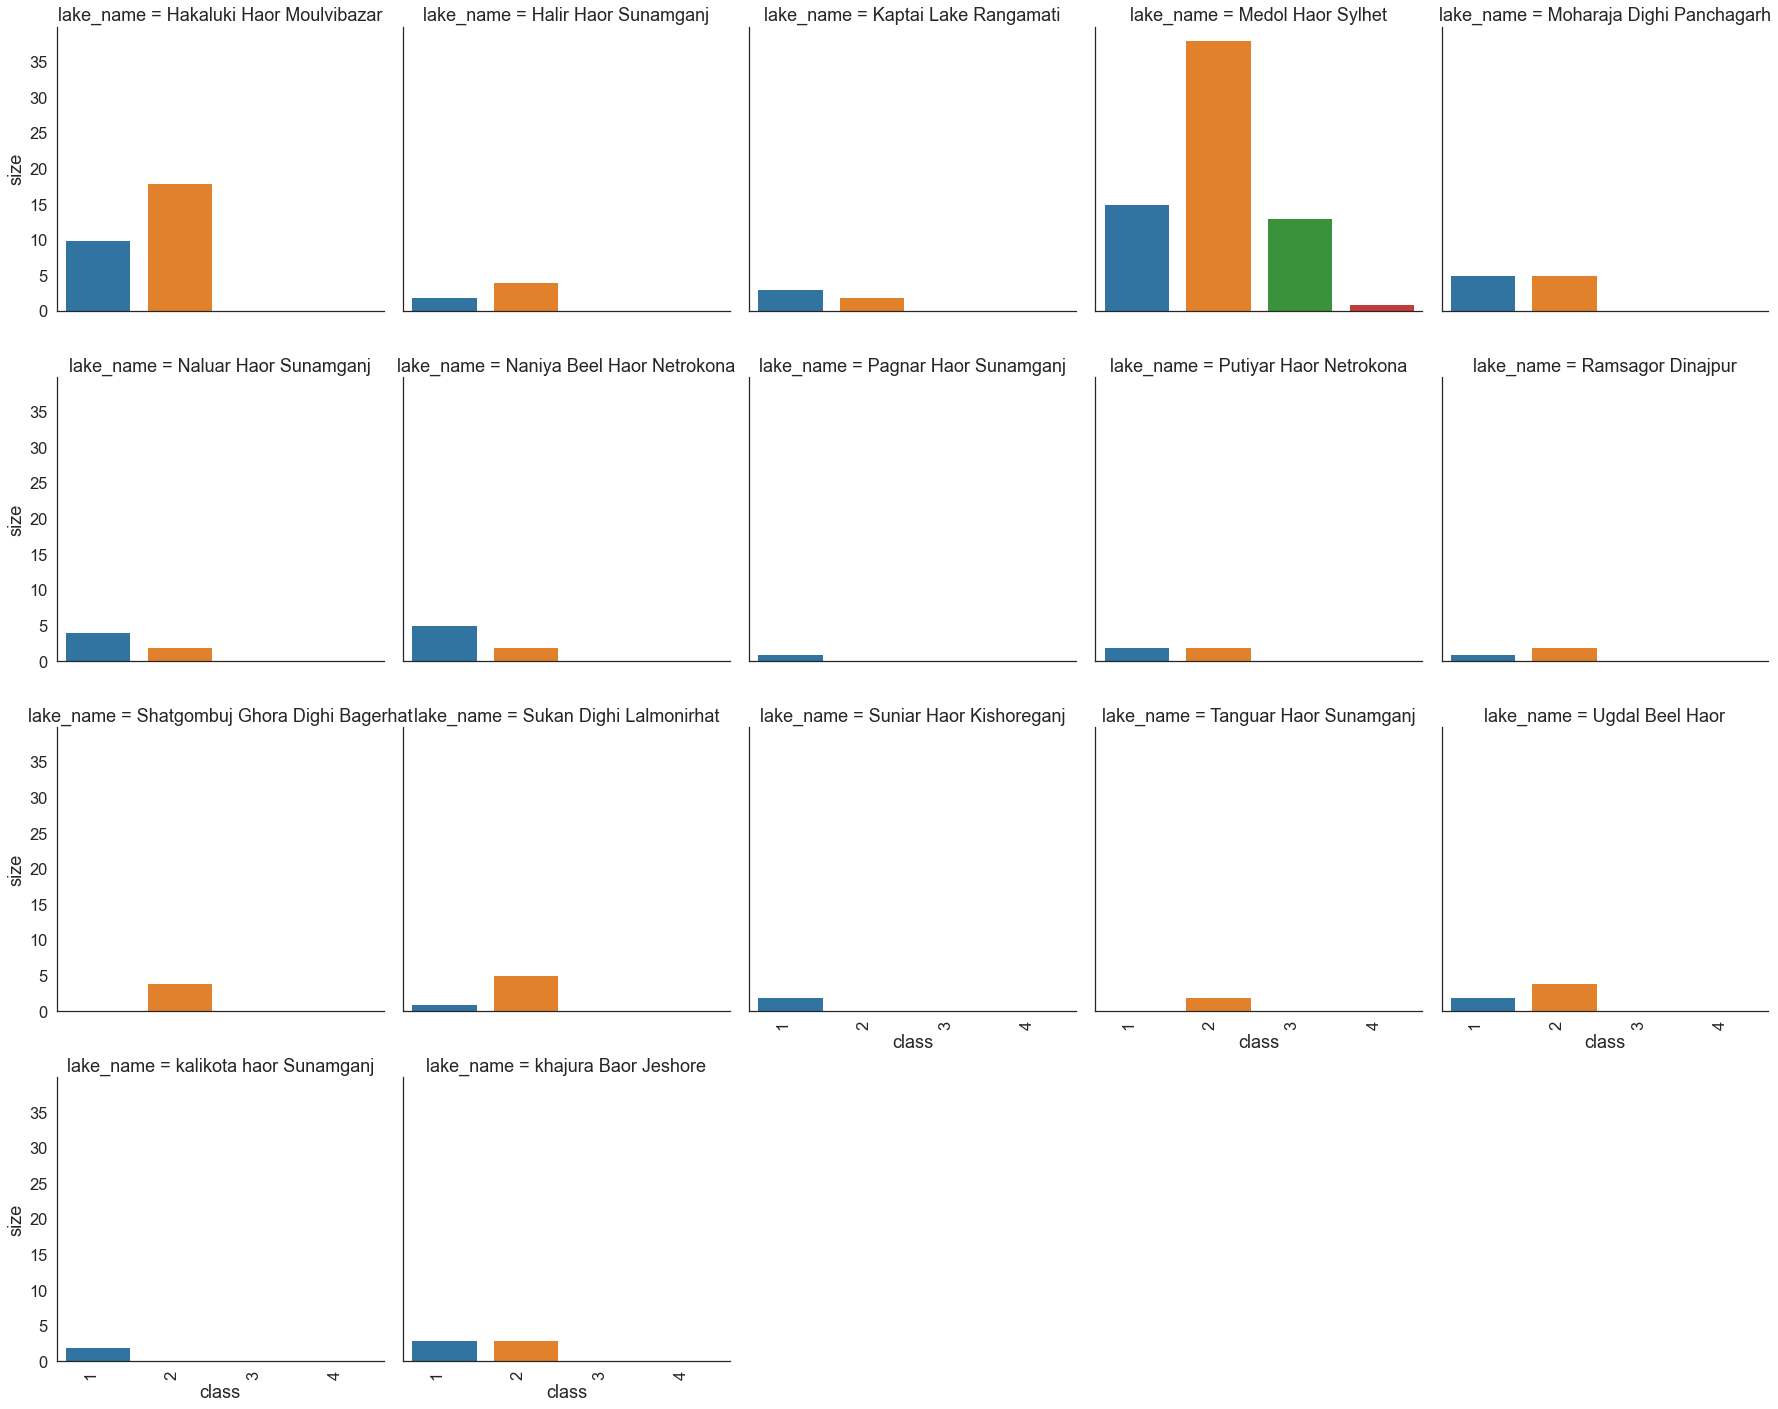

In [115]:
import seaborn as sns
from datetime import date

sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

df=df_dp
x_field=date_fd
y_field='diff_val'
hue='is_0'
col=lk_name_fd
col_wrap=4
facet_kws={'sharey': False, 'sharex': True}
#Split the figure in two
idx_first=int(len(df[lk_name_fd].unique())/2-1)
idx_last=int(len(df[lk_name_fd].unique())/2)
first_set=df[lk_name_fd].unique()[:idx_first]
last_set=df[lk_name_fd].unique()[idx_last:]

g_sn=sns.relplot(data=df.loc[df[lk_name_fd].isin(first_set)], 
                 x=x_field, y=y_field, hue=hue, 
                 col=col,col_wrap=col_wrap, facet_kws=facet_kws)
g_sn.set_xticklabels(rotation=90, horizontalalignment='right')
g_sn.savefig('../data/dup_bg_by_date_lake_1_'+date.today().strftime("%Y%m%d")+'.png')

g_sn=sns.relplot(data=df.loc[df[lk_name_fd].isin(last_set)], 
                 x=x_field, y=y_field, hue=hue, 
                 col=col,col_wrap=col_wrap, facet_kws=facet_kws)
g_sn.set_xticklabels(rotation=90, horizontalalignment='right')
g_sn.savefig('../data/dup_bg_by_date_lake_2_'+date.today().strftime("%Y%m%d")+'.png')

# g_num=sns.relplot(data=df_count_dp, x=x_field, y='size', col=col,col_wrap=col_wrap)
# g_num.set_xticklabels(rotation=90, horizontalalignment='right')

first_set=df_count_dp_by_lake[lk_name_fd].unique()[:idx_first]
last_set=df_count_dp_by_lake[lk_name_fd].unique()[idx_last:]
df=df_count_dp_by_lake.loc[df_count_dp_by_lake[lk_name_fd].isin(first_set)]

g_num=sns.catplot(data=df, x='class', y='size', col=col,col_wrap=5, kind='bar')
g_num.set_xticklabels(rotation=90, horizontalalignment='right')
g_num.savefig('../data/dup_bg_count_by_lake_class_1_'+date.today().strftime("%Y%m%d")+'.png')

df=df_count_dp_by_lake.loc[df_count_dp_by_lake[lk_name_fd].isin(last_set)]

g_num=sns.catplot(data=df, x='class', y='size', col=col,col_wrap=5, kind='bar')
g_num.set_xticklabels(rotation=90, horizontalalignment='right')
g_num.savefig('../data/dup_bg_count_by_lake_class_2_'+date.today().strftime("%Y%m%d")+'.png')

In [84]:
df_dp_diff=df_final.drop_duplicates(subset=[date_fd, lk_name_fd], keep='last').copy()#.loc[df_duplicates['diff_val']!=0]

df_dp_diff.head()

,Date,height,source,lake_name,diff_val,diff_date,Unnamed: 2
1,2021-09-01 09:00:00,7.25,LOCSS,Medol Haor Sylhet,0.00,0,NaN
3,2021-09-01 15:00:00,7.21,LOCSS,Medol Haor Sylhet,-0.05,0,NaN
4,2021-09-02 09:00:00,10.11,LOCSS,Medol Haor Sylhet,2.90,1080,NaN
5,2021-09-02 15:00:00,10.10,LOCSS,Medol Haor Sylhet,-0.01,360,NaN
6,2021-09-03 09:00:00,11.01,LOCSS,Medol Haor Sylhet,0.91,1080,NaN


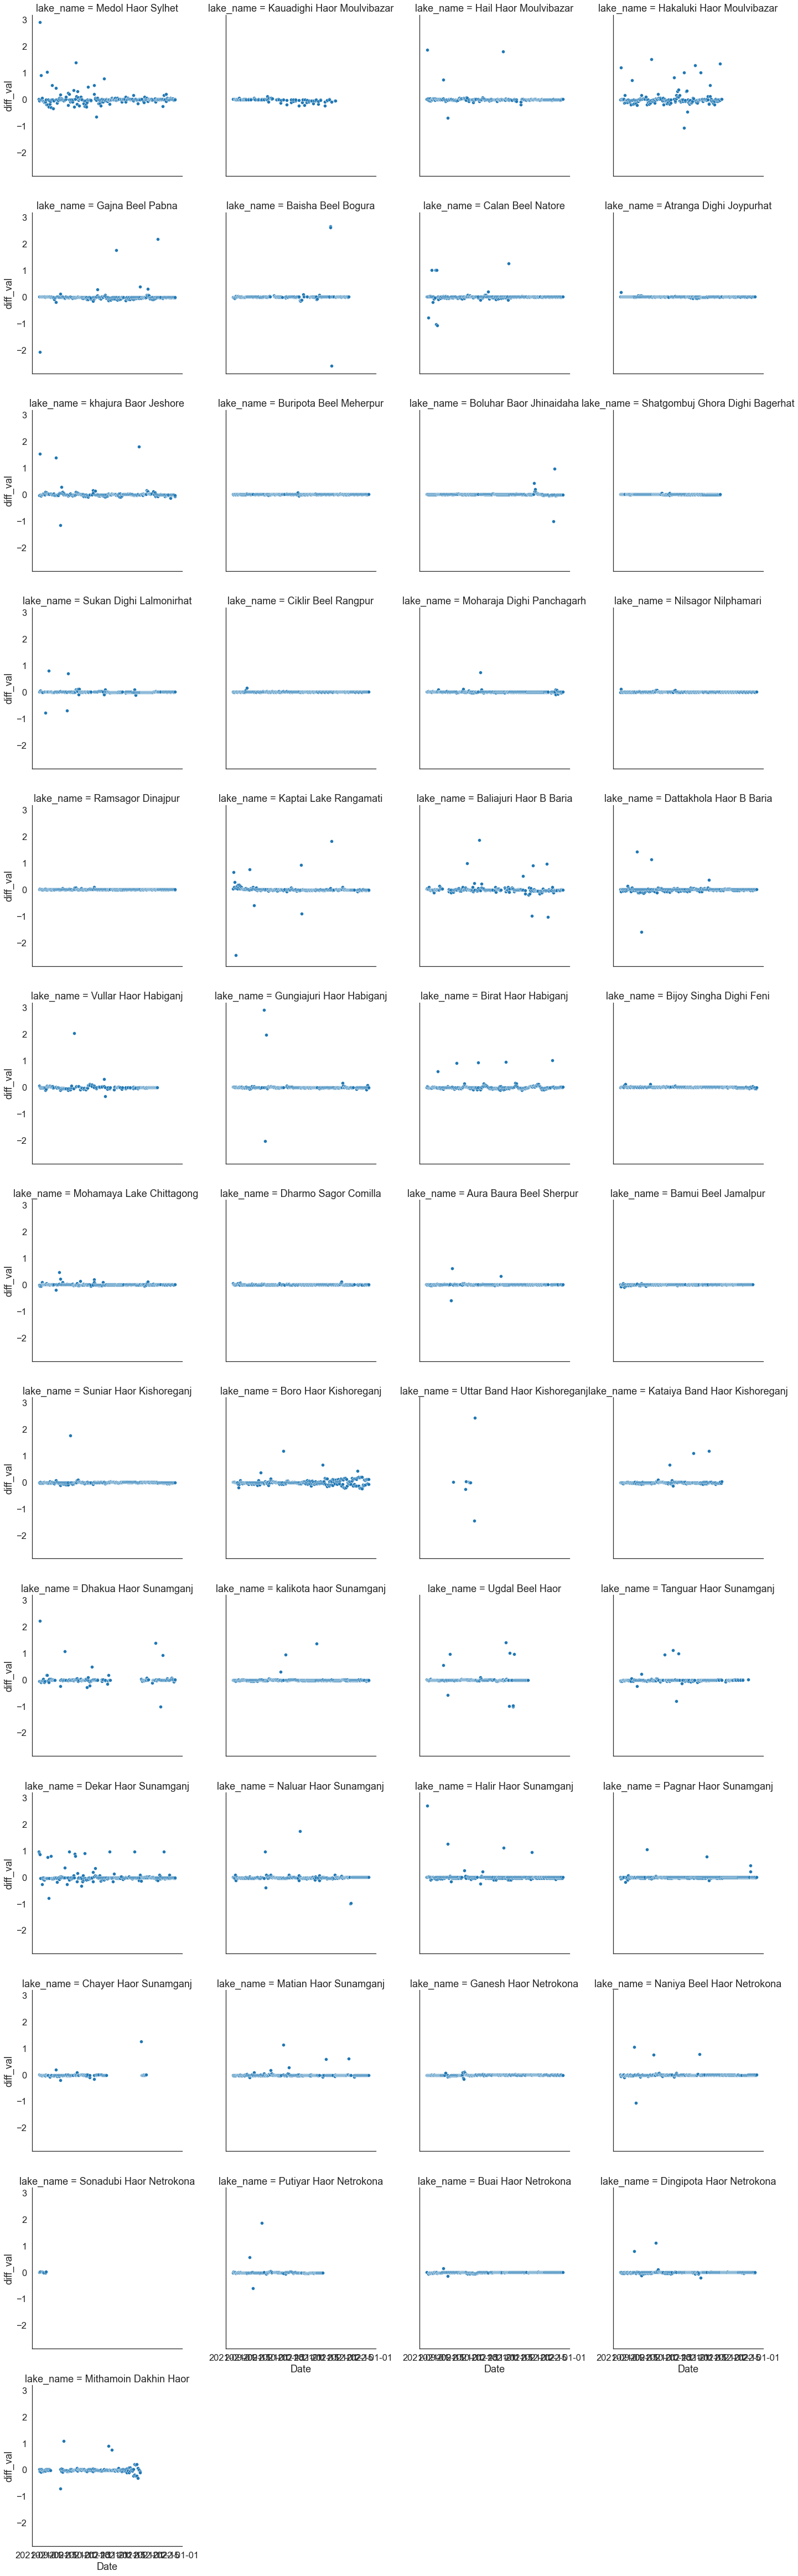

In [87]:

sns.relplot(data=df_dp_diff, x=date_fd,y='diff_val',col=lk_name_fd, col_wrap=4,kind='scatter')